In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats.stats import pearsonr
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import util
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler

In [23]:
data = pd.read_csv('../data/all_data.csv',index_col=0)

In [14]:
import config as cg

In [15]:
cg.dropcol

['artist.id',
 'artist.name',
 'artist_mbtags',
 'artist_mbtags_count',
 'song.id',
 'longitude',
 'release.name',
 'song.hotttnesss',
 'artist.id',
 'year',
 'release.id',
 'terms',
 'title',
 'location',
 'latitude',
 'country',
 'similar',
 'Youtube_Hotness',
 'similar_hotness',
 'mbtag_0',
 'mbtag_1',
 'mbtag_2']

In [24]:
data.columns

Index(['Youtube_Hotness', 'artist.hotttnesss', 'artist.id', 'artist.name',
       'artist_mbtags', 'artist_mbtags_count', 'bars_confidence', 'bars_start',
       'beats_confidence', 'beats_start', 'duration', 'end_of_fade_in',
       'familiarity', 'key', 'key_confidence', 'latitude', 'location',
       'longitude', 'loudness', 'mode', 'mode_confidence', 'release.id',
       'release.name', 'similar', 'song.hotttnesss', 'song.id',
       'start_of_fade_out', 'tatums_confidence', 'tatums_start', 'tempo',
       'terms', 'terms_freq', 'time_signature', 'time_signature_confidence',
       'title', 'year', 'decade', 'artist_firstname', 'artist_lastname',
       'mbtags_count', 'mbtag_0', 'mbtag_1', 'mbtag_2', 'similar_hotness',
       'term_id', 'title_neg', 'title_neu', 'title_pos', 'title_compound',
       'release.name_neg', 'release.name_neu', 'release.name_pos',
       'release.name_compound', 'y_fit_release', 'y_fit_title', 'y_fit_term',
       'release_svd_1_10', 'release_svd_2_10',

In [16]:
kept = list(set(data.columns)-set(cg.dropcol))#-set(cg.mbtag))

In [17]:
np.sort(kept)

array(['artist.hotttnesss', 'artist.hotttnesss.1', 'artist.id.1',
       'artist.name.1', 'artist_firstname', 'artist_firstname.1',
       'artist_freq', 'artist_freq.1', 'artist_lastname',
       'artist_lastname.1', 'artist_mbtags.1', 'artist_mbtags_count.1',
       'bars_confidence', 'bars_confidence.1', 'bars_start',
       'bars_start.1', 'beats_confidence', 'beats_confidence.1',
       'beats_start', 'beats_start.1', 'country_foreign',
       'country_unknown', 'country_us', 'decade', 'decade.1', 'duration',
       'duration.1', 'end_of_fade_in', 'end_of_fade_in.1', 'familiarity',
       'familiarity.1', 'grammy_relevance', 'hotness', 'key', 'key.1',
       'key_confidence', 'key_confidence.1', 'latitude.1', 'location.1',
       'longitude.1', 'loudness', 'loudness.1', 'mbtag_0.1', 'mbtag_1.1',
       'mbtag_2.1', 'mbtags_count', 'mbtags_count.1', 'mode', 'mode.1',
       'mode_confidence', 'mode_confidence.1', 'release.id.1',
       'release.name.1', 'release.name_compound',
   

In [32]:
# real = []
# possible_repeat = []
# for i in kept:
#     if i[-2:]=='.1':
#         possible_repeat.append(i)
#     else:
#         real.append(i)

# repeat = []
# for i in possible_repeat:
#     if i[:-2] in real:
#         print(i)
#         repeat.append(i)

In [33]:
# drop1 = set(original.columns).intersection(set(cg.dropcol))

In [34]:
# drop2 = set(original.columns).intersection(set(cg.mbtag))

In [35]:
#mini_data = original.drop(columns = list(drop1)+list(drop2))

In [36]:
#mini_data = original[kept]
#mini_data = mini_data.dropna()

In [159]:
mini_data = data[kept]
mini_data = mini_data.dropna()

In [160]:
X = mini_data.drop(columns=['hotness'])
y = [-1 if i<0 else i for i in mini_data['hotness'].values]

In [161]:
year = pd.get_dummies(X['decade'])
colname = []
for i in year.columns:
    colname.append('year'+str(i))
year.columns=colname

In [162]:
X = pd.concat([X,year],axis = 1)
X = X.drop(columns = ['decade'])

In [163]:
terms = pd.get_dummies(X['term_id'])

In [164]:
colname=[]
for i in terms.columns:
    colname.append('term'+str(i))

In [165]:
terms.columns = colname
X = pd.concat([X,terms],axis = 1)
X = X.drop(columns = ['term_id'])

In [166]:
# country = pd.get_dummies(X['country'])
# colname = []
# for i in country.columns:
#     colname.append('country'+str(i))
# country.columns = colname
# X = pd.concat([X,country],axis = 1)
# X = X.drop(columns = ['country'])

In [167]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [168]:
X.columns

Index(['title_svd_1_10.1', 'bars_confidence.1', 'release.name.1',
       'start_of_fade_out.1', 'title_neu', 'release_svd_3_10',
       'time_signature_confidence.1', 'song.hotttnesss.1', 'title_compound.1',
       'title_neg.1',
       ...
       'term327', 'term332', 'term351', 'term356', 'term381', 'term383',
       'term413', 'term419', 'term433', 'term444'],
      dtype='object', length=302)

In [169]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),columns =X_train.columns)

ValueError: could not convert string to float: 'Furry Lewis'

In [170]:
X_test = pd.DataFrame(scaler.transform(X_test),columns =X_test.columns)

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [171]:
from sklearn.model_selection import GridSearchCV

In [172]:
params = {'alpha':np.linspace(0.5,10,50)}
lasso = Lasso()
best_lasso = GridSearchCV(lasso,params,cv=3)

In [173]:
best_lasso.fit(X_train,y_train)

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: could not convert string to float: 'Coda'

In [174]:
best_lasso.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [175]:
clf = Lasso(alpha=best_lasso.best_params_['alpha'])
clf.fit(X_train,y_train)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [176]:
X.columns[abs(clf.coef_)>0]

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

In [65]:
from sklearn.metrics import mean_squared_error, r2_score

In [66]:
mean_squared_error(clf.predict(X_train),y_train)

24.761266700547793

In [57]:
mean_squared_error(clf.predict(X_test),y_test)

24.170898802890665

In [67]:
r2_score(clf.predict(X_train),y_train)

-50.47547377832672

In [68]:
from sklearn.ensemble import RandomForestRegressor

In [69]:
params = {'max_depth':[3,5,10,15,20],
         'n_estimators':[10,50,100]}
forest = RandomForestRegressor(random_state=0)
best_forest = GridSearchCV(forest,params,cv=3)

[3,5,8]
[10,30,50]

In [70]:
best_forest.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 5, 10, 15, 20], 'n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [71]:
mean_squared_error(best_forest.predict(X_train),y_train)

9.79357177703936

In [72]:
best_forest.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [73]:
mean_squared_error(best_forest.predict(X_test),y_test)

17.037016925480593

In [74]:
rank_df = pd.DataFrame({'importance':best_forest.best_estimator_.feature_importances_,
              'feature':X_train.columns}).sort_values(by='importance',
                                                      ascending=False)

In [75]:
accu_importance = [np.sum(rank_df['importance'][:i]) for i in range(1,len(rank_df)+1)]

In [76]:
rank_df['accumulated importance'] = accu_importance 


In [141]:
rank_df.head(30)

,importance,feature,accumulated importance
0,0.378218,artist_freq,0.378218
13,0.125576,artist.hotttnesss,0.503794
23,0.042749,loudness,0.546543
45,0.033700,year0,0.580243
38,0.021328,start_of_fade_out,0.601571
41,0.018399,duration,0.619970
37,0.015128,tempo,0.635098
33,0.014475,release_svd_7_10,0.649573
32,0.014023,bars_start,0.663596
24,0.013705,title_svd_2_10,0.677301


In [142]:
selected = rank_df.head(30)['feature']

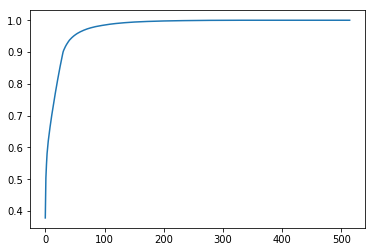

In [146]:
plt.plot(rank_df['accumulated importance'].values)

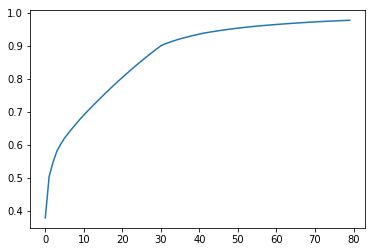

In [150]:
plt.plot(rank_df['accumulated importance'].values[:80])

In [80]:
r2_score(best_forest.predict(X_train),y_train)

0.09314999834603288

In [81]:
r2_score(best_forest.predict(X_test),y_test)

-0.8761543865485526

In [82]:
best_forest.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [151]:
clf = RandomForestRegressor(n_estimators=100, max_depth=10,
                         random_state=0)
clf.fit(X_train[selected], y_train) 
print(r2_score(clf.predict(X_train[selected]),y_train))
print(r2_score(clf.predict(X_test[selected]),y_test))

0.16977245027224575
-0.9377115393936057


Index(['y_fit_release', 'y_fit_term', 'duration', 'loudness', 'artist_freq',
       'artist_firstname', 'y_fit_title', 'start_of_fade_out', 'tempo'],
      dtype='object')

In [84]:
import xgboost as xgb

In [85]:
# params = {'learning_rate':[0.01,0.1],
#          'colsample_bytree':[0.5,0.9],
#          'max_depth':[5,10],
#          'n_estimators':[50,100,200,500]}
# clf=xgb.XGBRegressor(objective ='reg:linear',
#                  n_jobs = 2,gpu_id=0,
#                  tree_method='gpu_hist')
# best_boost = GridSearchCV(clf,params,cv=2)

In [86]:
#best_boost.fit(X_train[selected],y_train)

In [127]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.7, 
                          learning_rate = 0.01,
                max_depth = 10, alpha = 0, 
                          n_estimators = 200,
                          tree_method='gpu_hist',
                         n_jobs = 2,gpu_id=0)

In [133]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, gpu_id=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=2,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_hist')

In [134]:
mean_squared_error(xg_reg.predict(X_train),y_train)

8.618728526025434

In [135]:
mean_squared_error(xg_reg.predict(X_test),y_test)

18.13456874660353

In [137]:
r2_score(xg_reg.predict(X_test),y_test)

-1.840431340159716

In [139]:
r2_score(xg_reg.predict(X_train),y_train)

0.07633228803439662